In [1]:
import os
import analysis_utils as au
import quick_metadata_plots as qmplt
import padeopsIO as pio
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
keylab = pio.budgetkey.key_labels()
from pathlib import Path
import random
import imageio
import shutil
import pandas as pd

import modred as mr

data_folder = "/Users/sky/src/HowlandLab/data"

In [2]:
def get_clean_data(file_name, data_folder = "/Users/sky/src/HowlandLab/data"):
    with xr.open_dataset(os.path.join(data_folder, file_name)) as ds:
        ds = ds.isel(time = slice(100, None))
    return ds

In [3]:
def plot_u(ds, t_idx, mean_val = 1):
    da = ds.u
    range_val = np.max(np.abs(mean_val - da))  # centered at 1
    fig = plot_field(da.isel(time = t_idx), mean_val - range_val, mean_val + range_val, "Streamwise Velocity", keylab['u'])
    return fig

def plot_p(ds, t_idx):
    da = ds.p
    range_val = np.max(np.abs(da))
    fig = plot_field(da.isel(time = t_idx), -range_val, range_val, "Streamwise Pressure", keylab['p'])
    return fig

def plot_vals(arr, min_val, max_val, title, label):
    fig = plot_field(arr, min_val, max_val, title, label)
    return fig

def plot_field(da, min_val, max_val, title, label):
    colormap = "bwr"
    fig, ax = plt.subplots(1, 1, dpi = 300)
    # plot velocity
    im = da.imshow(ax = ax, cmap = colormap, vmin = min_val, vmax = max_val, cbar = False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    cbar.ax.tick_params(axis='both', which='major', labelsize=12)
    cbar.set_label(label, fontsize=14)
    ax.set_title(title, size = 16)
    ax.set_xlabel(keylab['x'], size = 14)
    ax.set_ylabel(keylab['z'], size = 14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.tight_layout()
    return fig

def ms2fps( ms ):
    ''' Converts milliseconds to frames per second '''
    return 1000 / ms

def animate_field(ds, frame_function, anim_path, fps = 10, loop = False, **kwargs):
    # make a temporary directory
    fp_out = Path( anim_path ).resolve()
    fp_out_base = fp_out.stem
    dir_out = fp_out.parents[0]
    randstr = str(random.randint(1000000, 9999999) )
    dir_tmp = dir_out / f'xanim_tmp_{fp_out_base}.{randstr}'
    os.mkdir(dir_tmp)
    # plot data
    ntimes = len(ds.time)
    ndigits = len(str(ntimes))
    fp_list = []
    for i in range(ntimes):
        # try:
        fig = frame_function(ds, i, **kwargs)
        idx_str = str(i).zfill(ndigits)
        fn_out_ii = dir_tmp / f'xanim_tmpfile_{idx_str}.png'
        fig.savefig(fn_out_ii, dpi = 300)
        fp_list.append( dir_tmp / fn_out_ii )
        plt.close(fig)
        # except:
        #     break
    print(fp_list)
    frames = []
    for ii in range(ntimes):
        image = imageio.v2.imread(fp_list[ii])
        frames.append(image)

    duration = ms2fps( fps )
    imageio.mimsave(fp_out, frames, duration = duration, loop = loop)    
    shutil.rmtree(dir_tmp)


In [4]:
def get_u_pod_modes(ds, num_modes, **kwargs):
    return get_pod_modes(ds.u, num_modes, label = keylab['u'], **kwargs)

def get_p_pod_modes(ds, num_modes, **kwargs):
    return get_pod_modes(ds.p, num_modes, label = keylab['p'], **kwargs)

def get_pod_modes(da, num_modes, label = "", avg_val = None, plot = True, tidx = 0, **kwargs):
    da = da.transpose("x", "z", "time")
    da_mean = da.mean(dim = "time")
    da_prime = da - da_mean
    vecs = np.array(da_prime)
    nx, nz, nt = vecs.shape
    vecs = vecs.reshape(nx * nz, nt)
    POD_res = mr.compute_POD_arrays_snaps_method(vecs, list(mr.range(num_modes)))
    modes = POD_res.modes.reshape(nx, nz, num_modes)
    eigvals = POD_res.eigvals
    reconstruct = calc_reconstruct(POD_res, da_mean, num_modes, tidx, nx, nz)
    if plot:
        plot_pod_modes(modes, eigvals, avg_val, **kwargs)
        plot_reconstruction(reconstruct, **kwargs)
    return POD_res, reconstruct

def calc_reconstruct(POD_res, da_mean, num_modes, tidx, nx, nz):
    modes = POD_res.modes.reshape(nx, nz, num_modes)
    proj_coeffs = POD_res.proj_coeffs[0:num_modes, tidx]
    reconstruct = da_mean + np.sum([proj_coeffs[i] * modes[:, :, i] for i in range(modes.shape[2])], axis = 0)
    return reconstruct

def plot_pod_modes(modes, eigvals, avg_val, mode_path = None, **kwargs):
    nmodes = modes.shape[2]
    ncols = 2
    nrows = math.ceil(nmodes / ncols)
    fig, axes = plt.subplots(nrows, ncols, dpi = 300, figsize = (8, 6), sharex=True, sharey = True)
    if avg_val is None:
        avg_val = np.average(modes[:, :, :])
    range_val = np.max(np.abs(modes - avg_val))
    r, c = 0, 0
    e1 = eigvals[0]
    for i in range(nmodes):
        imode = modes[:, :, i]
        iax = axes[r, c]
        im = iax.imshow(imode.transpose(), cmap='bwr', vmin = avg_val - range_val, vmax = avg_val + range_val, extent=[-5,20,-2.5,2.5])
        iax.set_title(f"$\lambda_{i + 1} / \lambda_1$ = " + str(round(eigvals[i] / e1, ndigits=3)), size = 14)
        if c == 0:
            iax.set_ylabel(keylab['z'], size = 12)
        if r == nrows - 1:
            iax.set_xlabel(keylab['x'], size = 12)
        iax.tick_params(axis='both', which='major', labelsize=10)
        c += 1
        if c == ncols:
            c = 0
            r += 1
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.01, 0.25, 0.01, 0.5])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(axis='both', which='major', labelsize=12)
    fig.tight_layout()
    if mode_path is not None:
        fig.savefig(mode_path, dpi = 300)
    return

def plot_reconstruction(reconstruct, recon_path = None, **kwargs):
    fig = plot_field(reconstruct, min_val=0, max_val=2, title = "Reconstructed Streamwise Velocity", label = keylab["u"]);
    if recon_path is not None:
        fig.savefig(recon_path, dpi = 300)
    return

## POD

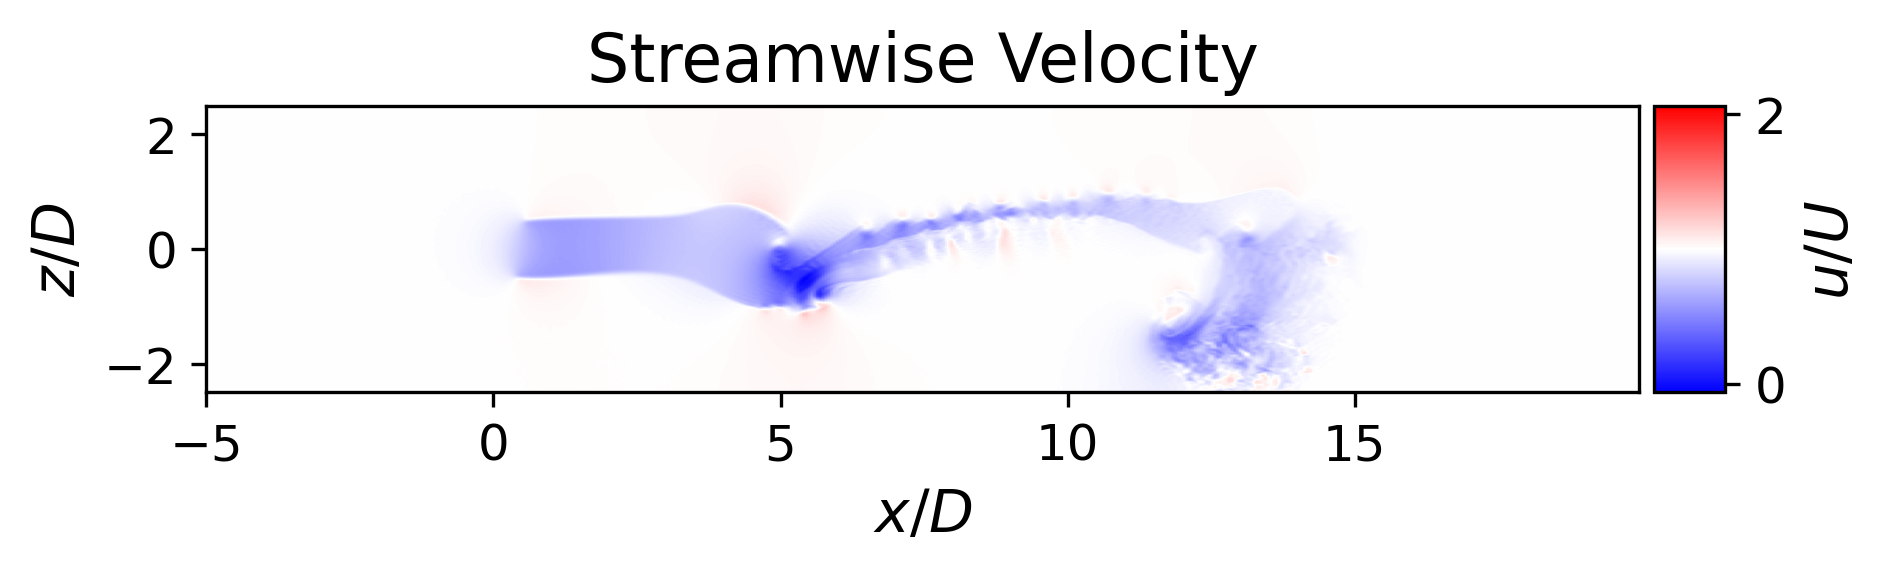

In [5]:
ds5 = get_clean_data("run05_data.nc")
tidx = 250
fig = plot_u(ds5, tidx, mean_val=1);
fig.savefig(os.path.join(data_folder, "init_u_250.png"), dpi = 300)

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_48093/349712738.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


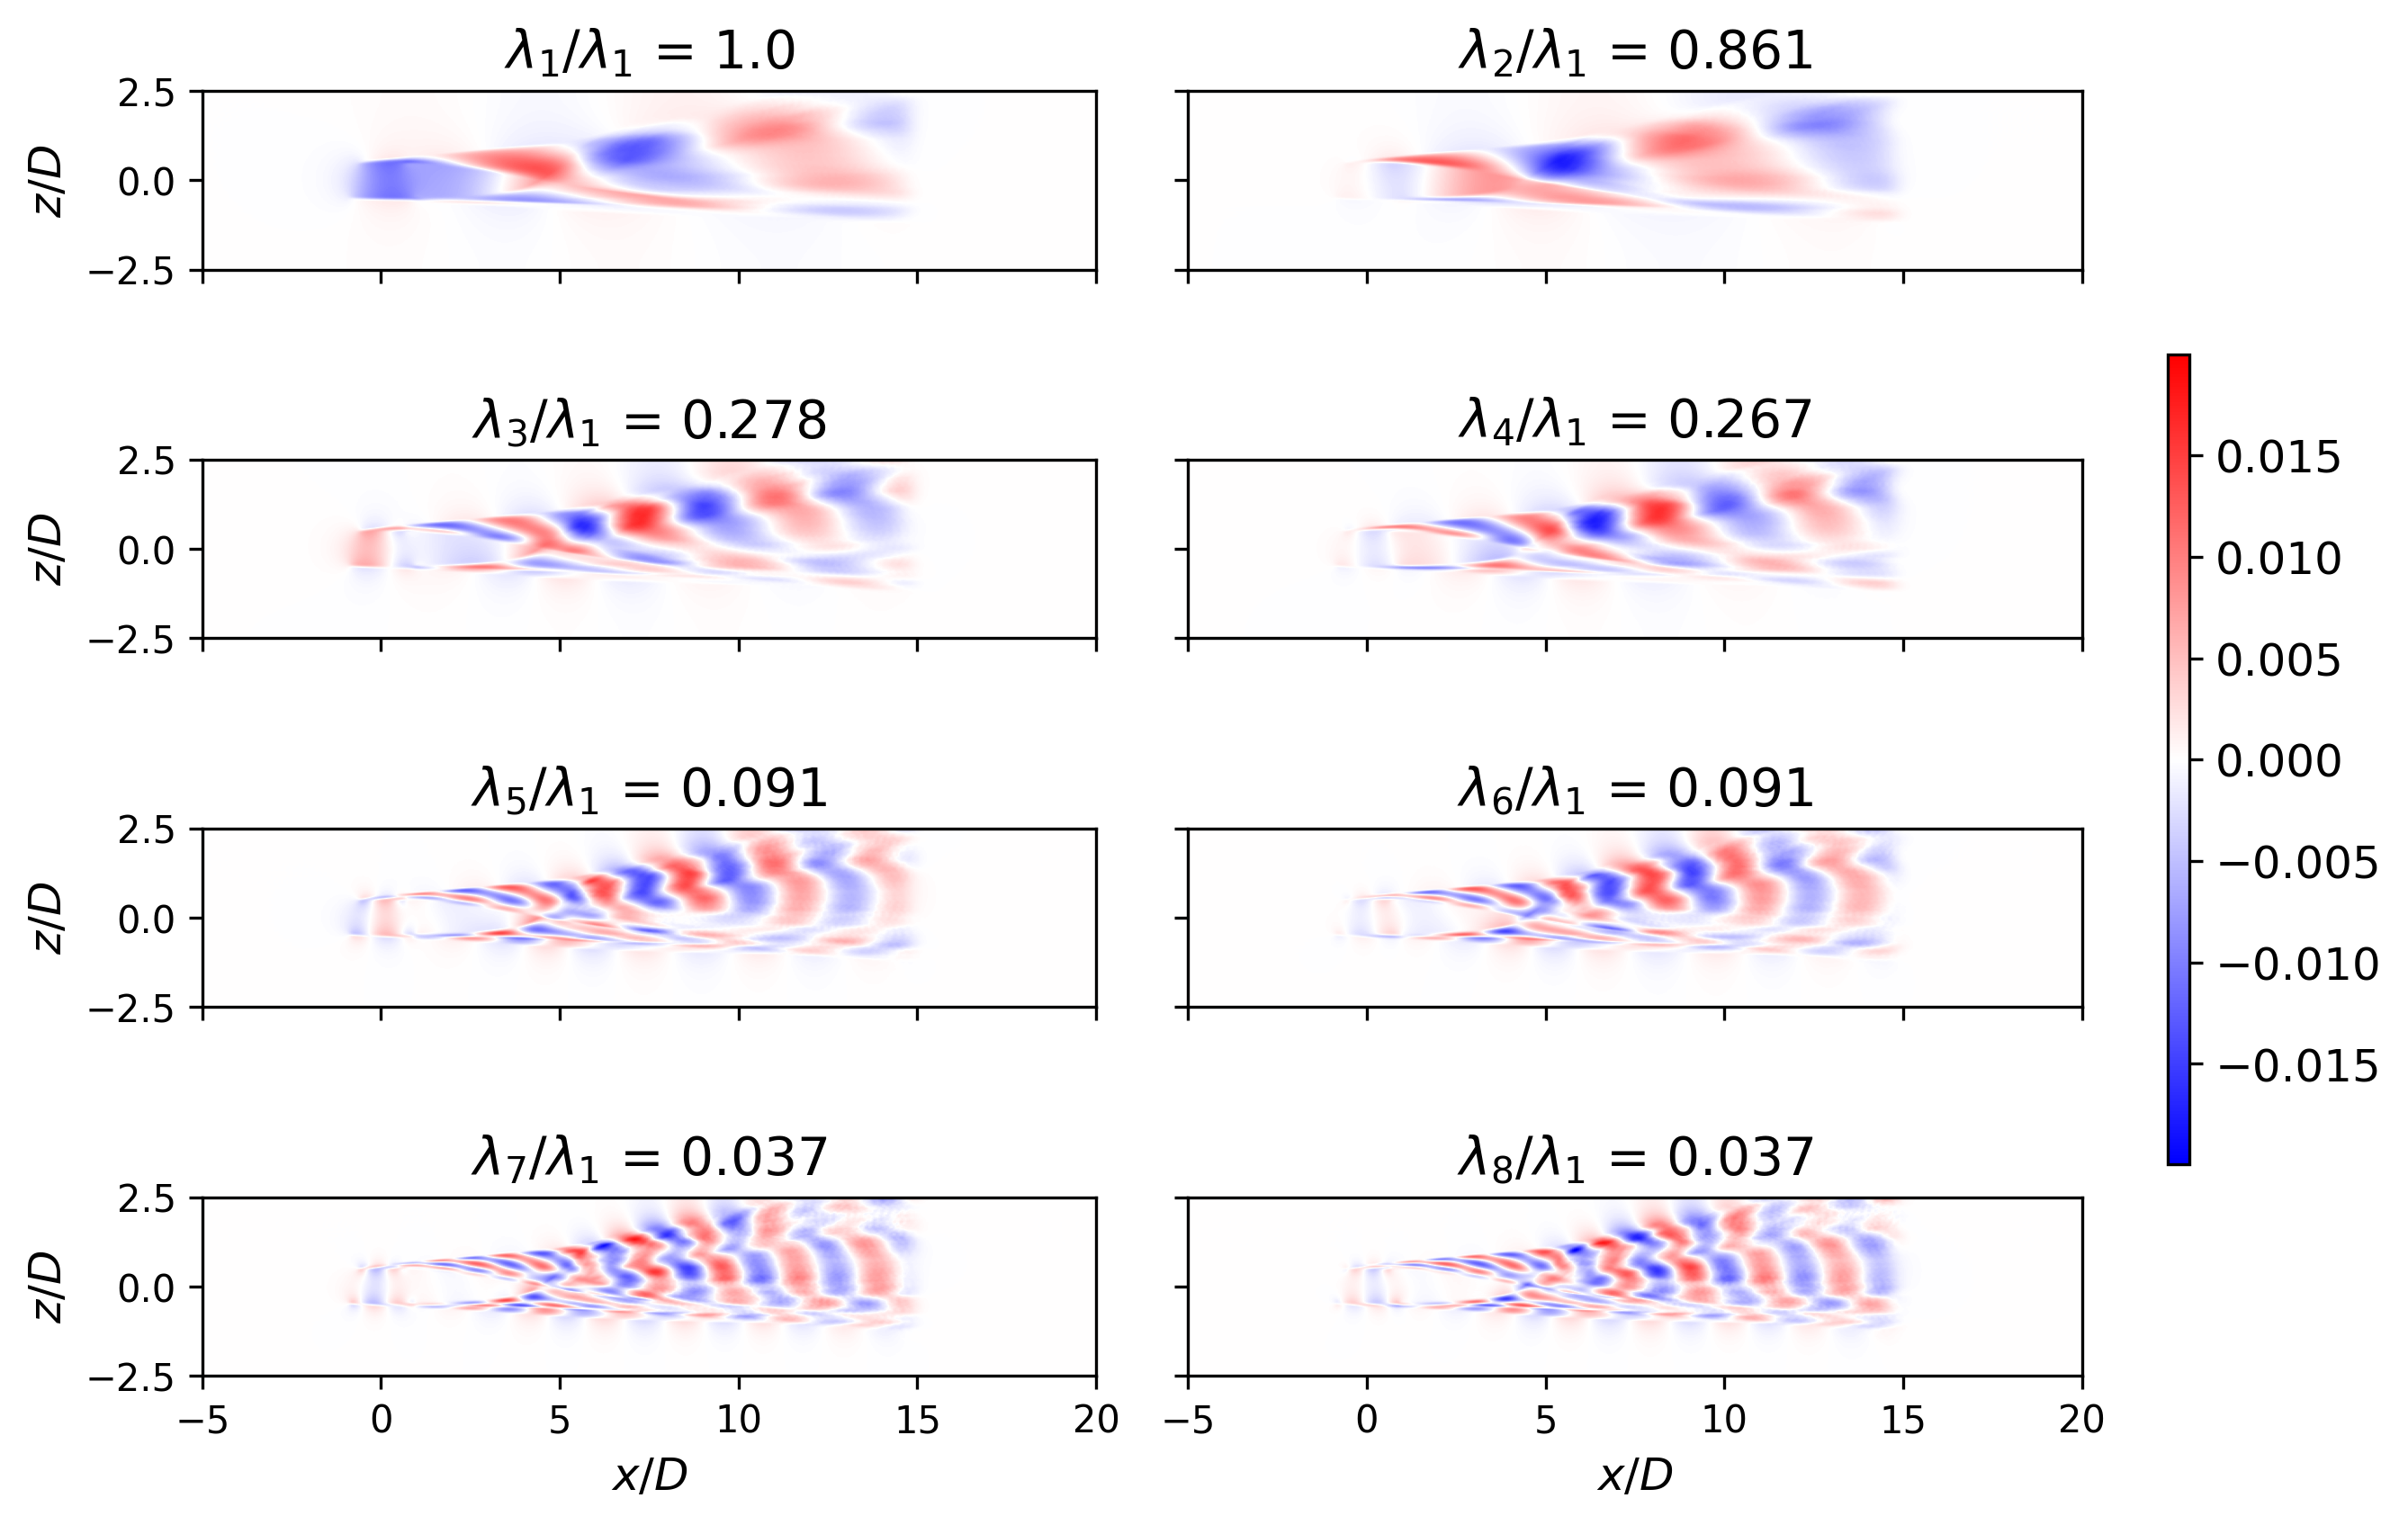

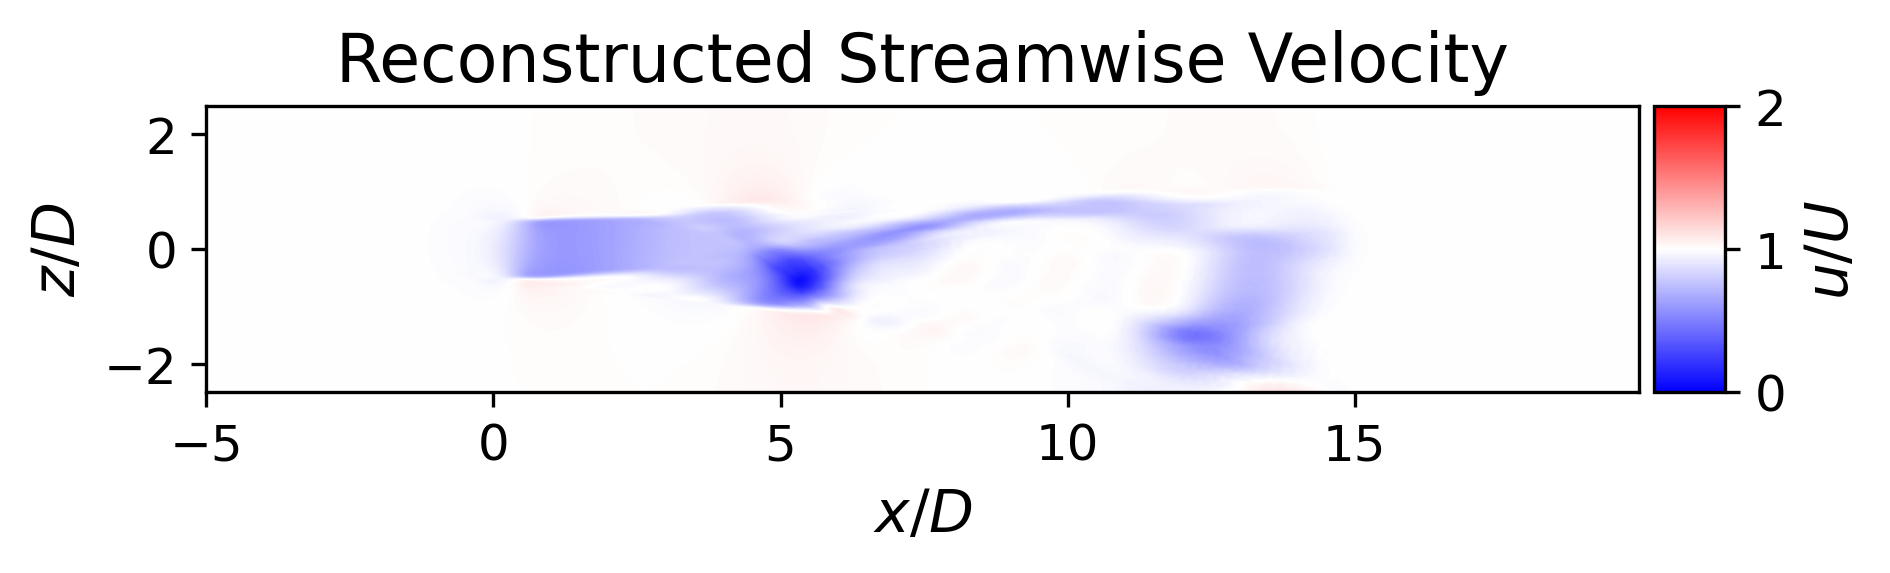

In [6]:
nmodes = 8
POD_res, reconstruct = get_u_pod_modes(ds5, nmodes, tidx = tidx, mode_path = os.path.join(data_folder, "pod_5.png"), recon_path = os.path.join(data_folder, "recon_5.png"))

In [7]:
POD_res.modes.shape

(131072, 8)

In [8]:
def rmse(ds, reconstruct, tidx):
    return math.sqrt((np.square(ds[tidx, :, :] - reconstruct)).mean())

In [9]:
nmodes = 8
da_mean = ds5.u.mean(dim = "time")
(nt, nx, nz) = ds5.u.shape
POD_res, reconstruct = get_u_pod_modes(ds5, nmodes, tidx = 0, plot = False)
rmse_vals = np.array([rmse(ds5.u, reconstruct, 0)])
for t in ds5["time"].values[1:]:
    reconstruct = calc_reconstruct(POD_res, da_mean, 8, tidx, nx, nz)
    POD_res, reconstruct = get_u_pod_modes(ds5, nmodes, tidx = t, plot = False)
    rmse_vals = np.append(rmse_vals, rmse(ds5.u, reconstruct, t))
rmse_vals

array([0.02895245, 0.02910949, 0.02944565, 0.02991275, 0.0304062 ,
       0.03033504, 0.03012831, 0.02967235, 0.02902331, 0.02834261,
       0.02743761, 0.0264265 , 0.02550101, 0.02478008, 0.02421146,
       0.02362056, 0.02307874, 0.02257223, 0.02235213, 0.02236196,
       0.02251211, 0.02265206, 0.02280019, 0.02318835, 0.02335762,
       0.02333712, 0.02381216, 0.02445499, 0.02545768, 0.0261934 ,
       0.0263354 , 0.02645655, 0.02675221, 0.02716096, 0.02773708,
       0.02819669, 0.02864726, 0.02893846, 0.02877872, 0.02830605,
       0.02838132, 0.02819416, 0.02743497, 0.0267185 , 0.02629153,
       0.02648986, 0.02704208, 0.02758568, 0.0278951 , 0.02804706,
       0.02775384, 0.02709716, 0.02652846, 0.02622181, 0.0257671 ,
       0.02515551, 0.0249229 , 0.02476284, 0.02450765, 0.02429737,
       0.02421819, 0.02409925, 0.02390769, 0.02373453, 0.02370034,
       0.02374984, 0.02365543, 0.02359859, 0.02375734, 0.02410328,
       0.02469066, 0.02531123, 0.02555302, 0.0254754 , 0.02572

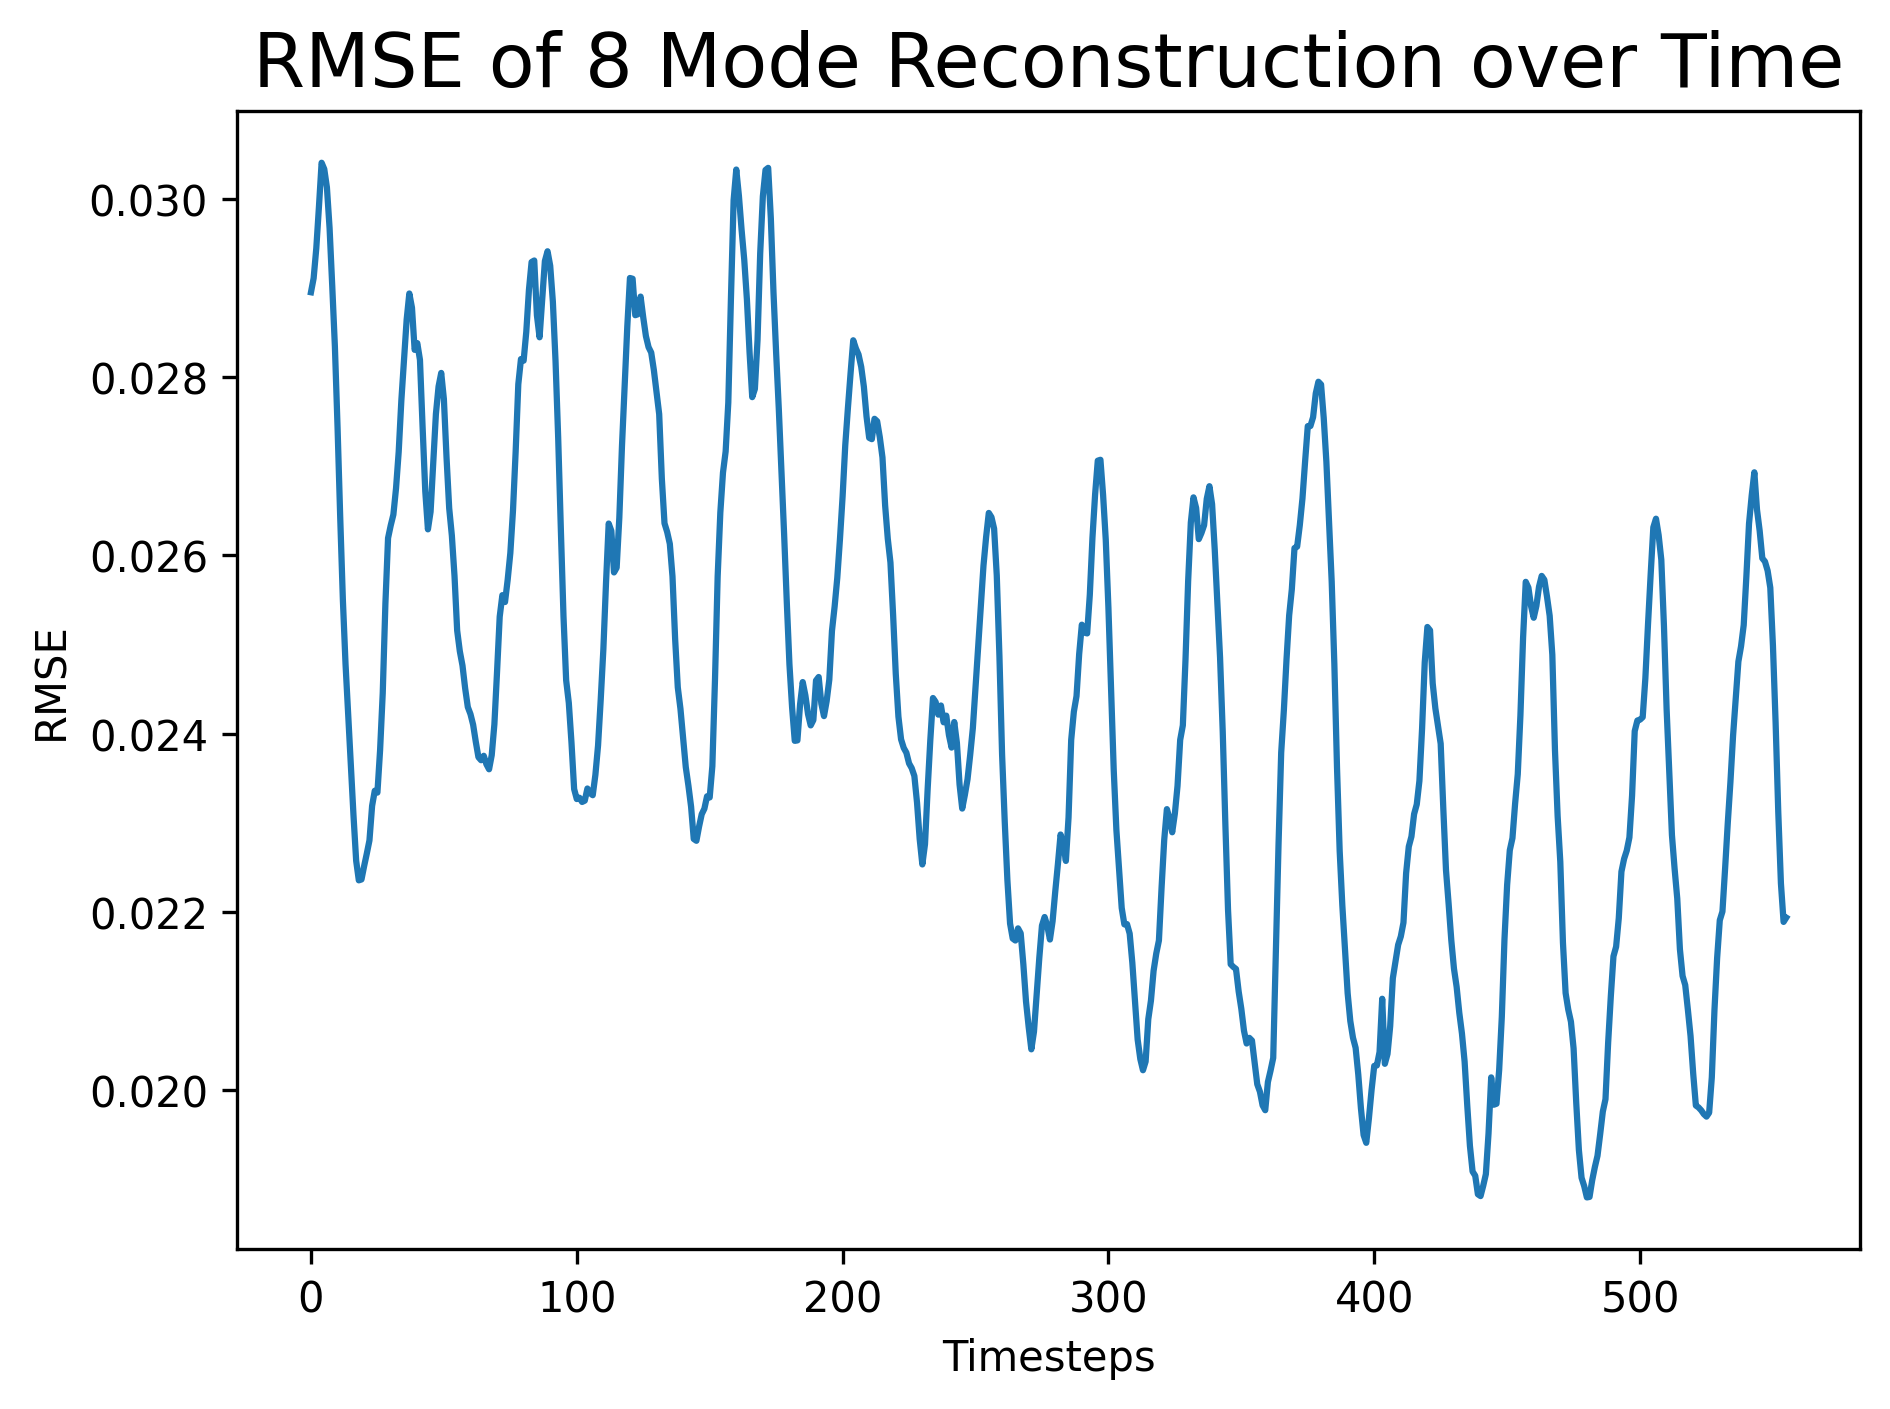

In [10]:
fig, ax = plt.subplots(1, 1, dpi = 300)
ax.plot(ds5["time"].values, rmse_vals)
ax.set_title("RMSE of 8 Mode Reconstruction over Time", size = 18)
ax.set_ylabel("RMSE")
ax.set_xlabel("Timesteps")
fig.tight_layout()
fig.savefig(os.path.join(data_folder, "pod_rmse.png"), dpi = 300)

In [11]:
np.average(rmse_vals)

np.float64(0.024301612286899595)

## Explore using different length time series

In [12]:
nmodes = 8
n_ndt = 3
rmse_vals = np.zeros(n_ndt)
modes = np.zeros((n_ndt, nmodes))
dt_vals = np.zeros(n_ndt)
tidx = 100
for (i, n_dt) in enumerate(range(200, 700, 200)):
    dt_vals[i] = n_dt
    ds_trimmed = ds5.isel(time = slice(0, n_dt))
    POD_res, reconstruct = get_u_pod_modes(ds_trimmed, nmodes, tidx = tidx, plot = False)
    rmse_vals[i] = rmse(ds_trimmed.u, reconstruct, tidx)
    modes[i] = POD_res.eigvals[:8]

dt_vals, rmse_vals, modes

(array([200., 400., 600.]),
 array([0.0227261 , 0.02291806, 0.02326457]),
 array([[ 56544.08257954,  50481.99480293,  16167.99107874,
          15747.07229758,   5354.77252991,   5306.7727043 ,
           2253.60487625,   2238.93067412],
        [110753.73507455,  97222.0710459 ,  31321.26225505,
          30082.89854432,  10246.50291464,  10119.61118742,
           4236.44014145,   4197.84624826],
        [153514.85937127, 132134.85424895,  42749.70034709,
          41039.35804359,  14028.6865425 ,  13893.74325306,
           5747.72551468,   5707.36047918]]))

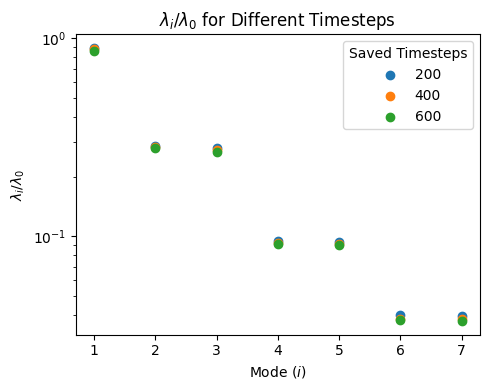

In [13]:
fig, ax0 = plt.subplots(1, 1, figsize = (5, 4))
colors = ['tab:blue', 'tab:orange', 'tab:green']
for (i, nt) in enumerate(dt_vals):
    ax0.scatter(range(1, len(modes[i])), modes[i][1:] / modes[i, 0], color = colors[i], label = str(round(nt)))

ax0.set_yscale('log')
ax0.set_ylabel("$\lambda_i / \lambda_0$")
ax0.set_xlabel("Mode ($i$)")
ax0.legend(title = "Saved Timesteps")
ax0.set_title("$\lambda_i / \lambda_0$ for Different Timesteps")
fig.tight_layout()
fig.savefig(os.path.join(data_folder, "timestep_effect_5.png"), dpi = 300)

In [14]:
# fig, ax0 = plt.subplots(1, 1, figsize = (5, 4))
# ax0.scatter(dt_vals, rmse_vals)
# ax0.set_ylabel("RMSE")
# ax0.set_xlabel("# of Saved Timesteps")
# ax0.set_title("RMSE of Reconstruction with 8 Modes")
# fig.tight_layout()
# fig.savefig(os.path.join(data_folder, "timestep_effect_rmse_5.png"), dpi = 300)

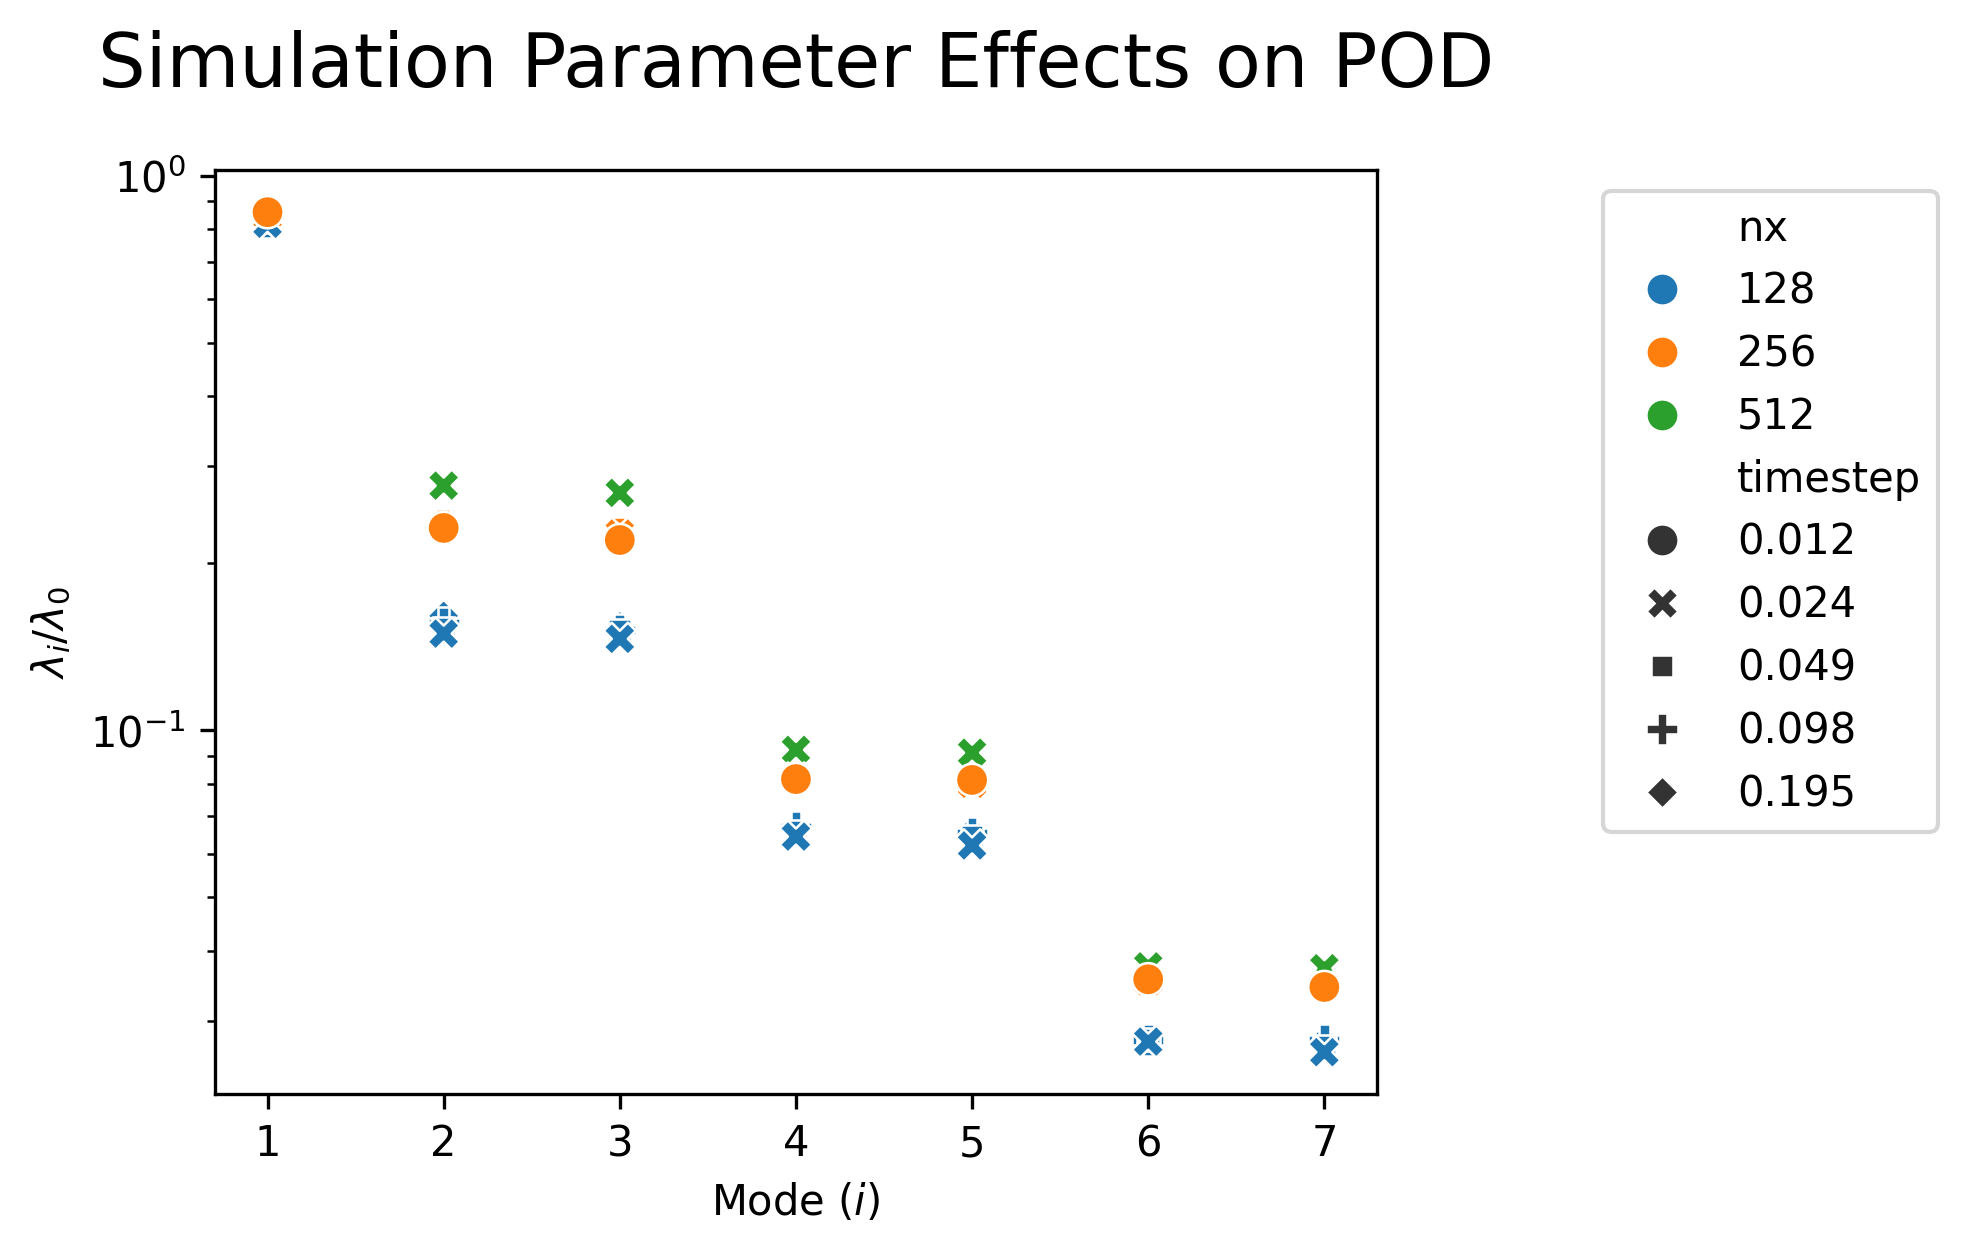

In [15]:
import seaborn as sns
pod_df = pd.read_csv(os.path.join(data_folder, "new_pod_data.csv"))
pod_df["timestep"] = pod_df.apply(lambda row: round(row["dt"], ndigits = 3), axis = 1)
pod_df_ratio = pod_df[pod_df["mode"] != 0]

fig, ax0 = plt.subplots(1, 1, figsize = (5, 4), dpi = 300)
sns.scatterplot(ax = ax0, data = pod_df_ratio, x = "mode", y = "e_ratio", hue = "nx", style = "timestep", palette="tab10", s = 60)
ax0.set_title("Simulation Parameter Effects on POD", size = 18, pad = 20)
ax0.set_yscale('log')
ax0.set_ylabel("$\lambda_i / \lambda_0$")
ax0.set_xlabel("Mode ($i$)")
leg = ax0.legend()
bb = leg.get_bbox_to_anchor().transformed(ax0.transAxes.inverted())
xOffset = 0.5
bb.x0 += xOffset
bb.x1 += xOffset
leg = leg.set_bbox_to_anchor(bb, transform = ax0.transAxes)
fig.savefig(os.path.join(data_folder, "pod_mode_convergence.png"), dpi = 300)

In [16]:
pod_df_small_dt = pod_df[pod_df["timestep"] == 0.024]
modes = pod_df_small_dt["mode"].unique()
modes.sort()
modes = modes[1:]
p_vals = [0 for _ in modes]
e_vals = [0 for _ in modes]
d24 = [0 for _ in modes]
d12 = [0 for _ in modes]
for (i, m) in enumerate(modes):
    mode_dt = pod_df_small_dt[pod_df_small_dt["mode"] == m]
    v4 = mode_dt[mode_dt["nx"] == 128]["e_ratio"].values[0]
    v2 = mode_dt[mode_dt["nx"] == 256]["e_ratio"].values[0]
    v1 = mode_dt[mode_dt["nx"] == 512]["e_ratio"].values[0]
    d24[i] = v2 - v4
    d12[i] = v1 - v2
    p_vals[i] = np.log(d24[i] / d12[i]) / np.log(2)
e_vals = [abs(d12[i] / ((2**p) - 1)) for (i, p) in enumerate(p_vals)]

In [17]:
data = {'Modes': range(1, len(modes) + 1),
        "Low/Medium Difference": d24,
        "Medium/High Difference": d12,
        'Order of Accuracy': p_vals,
        '|Discretization Error|': e_vals}

# Create DataFrame
df = pd.DataFrame(data)
cm = sns.color_palette("vlag", as_cmap=True)
df.style.background_gradient(cmap=cm, subset = ["|Discretization Error|"])

,Modes,Low/Medium Difference,Medium/High Difference,Order of Accuracy,|Discretization Error|
0,1,0.024574,0.010355,1.246815,0.007541
1,2,0.083332,0.043414,0.940706,0.047217
2,3,0.080071,0.041668,0.942341,0.045211
3,4,0.017532,0.010344,0.761177,0.014887
4,5,0.018096,0.011023,0.715207,0.017177
5,6,0.007804,0.002267,1.783337,0.000928
6,7,0.008075,0.002890,1.482441,0.001611


In [18]:
pod_df_med_res = pod_df[pod_df["nx"] == 256]
modes = pod_df_med_res["mode"].unique()
modes.sort()
modes = modes[1:]
p_vals = [0 for _ in modes]
e_vals = [0 for _ in modes]
d24 = [0 for _ in modes]
d12 = [0 for _ in modes]
for (i, m) in enumerate(modes):
    mode_dt = pod_df_med_res[pod_df_med_res["mode"] == m]
    v4 = mode_dt[mode_dt["timestep"] == 0.049]["e_ratio"].values[0]
    v2 = mode_dt[mode_dt["timestep"] == 0.024]["e_ratio"].values[0]
    v1 = mode_dt[mode_dt["timestep"] == 0.012]["e_ratio"].values[0]
    d24[i] = v2 - v4
    d12[i] = v1 - v2
    p_vals[i] = np.log(d24[i] / d12[i]) / np.log(2)
e_vals = [abs(d12[i] / ((2**p) - 1)) for (i, p) in enumerate(p_vals)]

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_48093/3928187356.py:16: RuntimeWarning: invalid value encountered in log
  p_vals[i] = np.log(d24[i] / d12[i]) / np.log(2)


In [19]:
data = {'Modes': range(1, len(modes) + 1),
        "Low/Medium Difference": d24,
        "Medium/High Difference": d12,
        'Order of Accuracy': p_vals,
        '|Discretization Error|': e_vals}

# Create DataFrame
df = pd.DataFrame(data)
cm = sns.color_palette("vlag", as_cmap=True)
df.style.background_gradient(cmap=cm, subset = ["|Discretization Error|"])

,Modes,Low/Medium Difference,Medium/High Difference,Order of Accuracy,|Discretization Error|
0,1,-0.008870,0.015839,nan,nan
1,2,-0.005967,-0.001076,2.471667,0.000237
2,3,-0.005012,-0.005948,-0.246950,0.037807
3,4,-0.001549,-0.000179,3.109778,0.000024
4,5,-0.002062,0.001277,nan,nan
5,6,0.000208,0.000305,-0.547159,0.000965
6,7,-0.000583,0.000094,nan,nan


In [20]:
pod_df_med_res = pod_df[pod_df["nx"] == 128]
modes = pod_df_med_res["mode"].unique()
modes.sort()
modes = modes[1:]
p_vals = [0 for _ in modes]
e_vals = [0 for _ in modes]
d24 = [0 for _ in modes]
d12 = [0 for _ in modes]
for (i, m) in enumerate(modes):
    mode_dt = pod_df_med_res[pod_df_med_res["mode"] == m]
    v4 = mode_dt[mode_dt["timestep"] == 0.195]["e_ratio"].values[0]
    v2 = mode_dt[mode_dt["timestep"] == 0.098]["e_ratio"].values[0]
    v1 = mode_dt[mode_dt["timestep"] == 0.049]["e_ratio"].values[0]
    d24[i] = v2 - v4
    d12[i] = v1 - v2
    p_vals[i] = np.log(d24[i] / d12[i]) / np.log(2)
e_vals = [abs(d12[i] / ((2**p) - 1)) for (i, p) in enumerate(p_vals)]

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_48093/1000258261.py:16: RuntimeWarning: invalid value encountered in log
  p_vals[i] = np.log(d24[i] / d12[i]) / np.log(2)


In [21]:
data = {'Modes': range(1, len(modes) + 1),
        "Low/Medium Difference": d24,
        "Medium/High Difference": d12,
        'Order of Accuracy': p_vals,
        '|Discretization Error|': e_vals}

# Create DataFrame
df = pd.DataFrame(data)
cm = sns.color_palette("vlag", as_cmap=True)
df.style.background_gradient(cmap=cm, subset = ["|Discretization Error|"])

,Modes,Low/Medium Difference,Medium/High Difference,Order of Accuracy,|Discretization Error|
0,1,0.000516,-0.000415,nan,nan
1,2,-0.004669,-0.003621,0.366624,0.012517
2,3,-0.002297,-0.000097,4.561663,0.000004
3,4,0.000219,-0.001257,nan,nan
4,5,-0.000490,-0.001007,-1.039634,0.001961
5,6,-0.000056,0.000057,nan,nan
6,7,-0.000038,-0.000638,-4.075862,0.000678


## SPOD

In [22]:
import sys
SPOD_path = "/Users/sky/src/HowlandLab/spod_python"
sys.path.insert(0, SPOD_path)
import spod
import h5py
import pylab
from matplotlib import cm

In [23]:
save_fig  = True  # postprocess figs
save_path = data_folder

In [24]:
params={
'axes.labelsize': '20',
'xtick.labelsize': '16',
'ytick.labelsize': '16',
'lines.linewidth': 1.5,
'legend.fontsize': '14',
'figure.figsize': '8, 6'    # set figure size
}
pylab.rcParams.update(params)

def figure_format(xtitle, ytitle, zoom, legend):
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.axis(zoom)
    if legend != 'None':
        plt.legend(loc=legend)

In [25]:
ds5 = get_clean_data("run05_data.nc")
da = ds5.u
da = da.transpose("time", "x", "z")
da_mean = da.mean(dim = "time")
da_prime = da - da_mean
vecs = np.array(da_prime)
nt, nx, nz = vecs.shape
vecs = vecs.reshape(nt, nx * nz)
dt = 0.0244

In [26]:
spod.spod(vecs, dt, save_path, method='fast')

--------------------------------------
SPOD starts...
--------------------------------------
Using user specified method...
Using default weight...
Using default nDFT...
Using default Hamming window...
Using default nOvlp...
--------------------------------------
SPOD parameters summary:
--------------------------------------
number of DFT points : 32
number of blocks is  : 33
number of overlap is : 16
Window function      : Hamming
Weight function      : unity
Running method       : fast
--------------------------------------
Calculating temporal DFT
--------------------------------------
block 1 / 33 ( 1 : 32 )
block 2 / 33 ( 17 : 48 )
block 3 / 33 ( 33 : 64 )
block 4 / 33 ( 49 : 80 )
block 5 / 33 ( 65 : 96 )
block 6 / 33 ( 81 : 112 )
block 7 / 33 ( 97 : 128 )
block 8 / 33 ( 113 : 144 )
block 9 / 33 ( 129 : 160 )
block 10 / 33 ( 145 : 176 )
block 11 / 33 ( 161 : 192 )
block 12 / 33 ( 177 : 208 )
block 13 / 33 ( 193 : 224 )
block 14 / 33 ( 209 : 240 )
block 15 / 33 ( 225 : 256 )
block

In [27]:
SPOD_LPf  = h5py.File(os.path.join(save_path,'SPOD_LPf.h5'),'r')
L = SPOD_LPf['L'][:,:]    # modal energy E(f, M)
P = SPOD_LPf['P'][:,:,:]  # mode shape
f = SPOD_LPf['f'][:]      # frequency
SPOD_LPf.close()

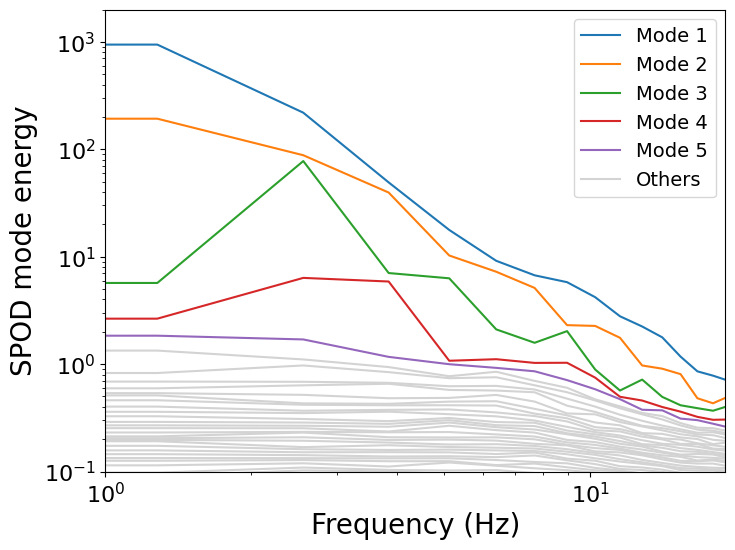

In [28]:
fig = spod.plot_spectrum(f,L,hl_idx=5)
figure_format(xtitle='Frequency (Hz)', ytitle='SPOD mode energy',
              zoom=[1, 1.9*10**1, 10**-1, 2*10**3], legend='best')

if save_fig:
    plt.savefig(os.path.join(save_path,'Spectrum.png'), dpi=300, bbox_inches='tight')
    plt.close()
fig

In [29]:
def plot_spod_modes(P, L, f, M_idxs, f_idxs, mode_path = None, nx = 512, nz = 256, label = "", avg_val = None, **kwargs):
    ncols = len(f_idxs)
    nrows = len(M_idxs) + 1
    fig, axes = plt.subplots(nrows, ncols, dpi = 300, sharex=True, sharey = True, gridspec_kw={'height_ratios': [0.5] + [4] * (nrows - 1)})
    fig.suptitle("SPOD Frequency Modes", size = 18)
    for (c, fj) in enumerate(f_idxs):
        axes[0, c].axis("off")
        axes[0, c].set_title(f"Frequency: {round(f[fj], 2)}", size = 15)

    modes_real = np.real(P[:,:,:])
    if avg_val is None:
        avg_val = np.average(modes_real)
    range_val = np.max(np.abs(modes_real - avg_val))
    for (i, Mi) in enumerate(M_idxs):
        for (j, fj) in enumerate(f_idxs):
            e1 = L[fj, 0]  # largest energy in a given frequency
            ijmode = modes_real[fj, : ,Mi]
            ijmode = ijmode.reshape(nx, nz)
            ijax = axes[i + 1, j]
            im = ijax.imshow(ijmode.transpose(), cmap='bwr', vmin = avg_val - range_val, vmax = avg_val + range_val, extent=[-5,20,-2.5,2.5])
            ijax.set_title(f"$\lambda_{Mi + 1} / \lambda_1$ = " + str(round(L[fj, Mi] / e1, ndigits=3)), size = 14)
            if j == 0:
                ijax.set_ylabel(keylab['z'], size = 12)
            if i == nrows - 2:
                ijax.set_xlabel(keylab['x'], size = 12)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.01, 0.25, 0.01, 0.5])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(axis='both', which='major', labelsize=12)
    fig.tight_layout()
    if mode_path is not None:
        fig.savefig(mode_path, dpi = 300)
    return

/var/folders/dt/wzb0_01j5yz8q2y9bz5sfjm00000gn/T/ipykernel_48093/289769827.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


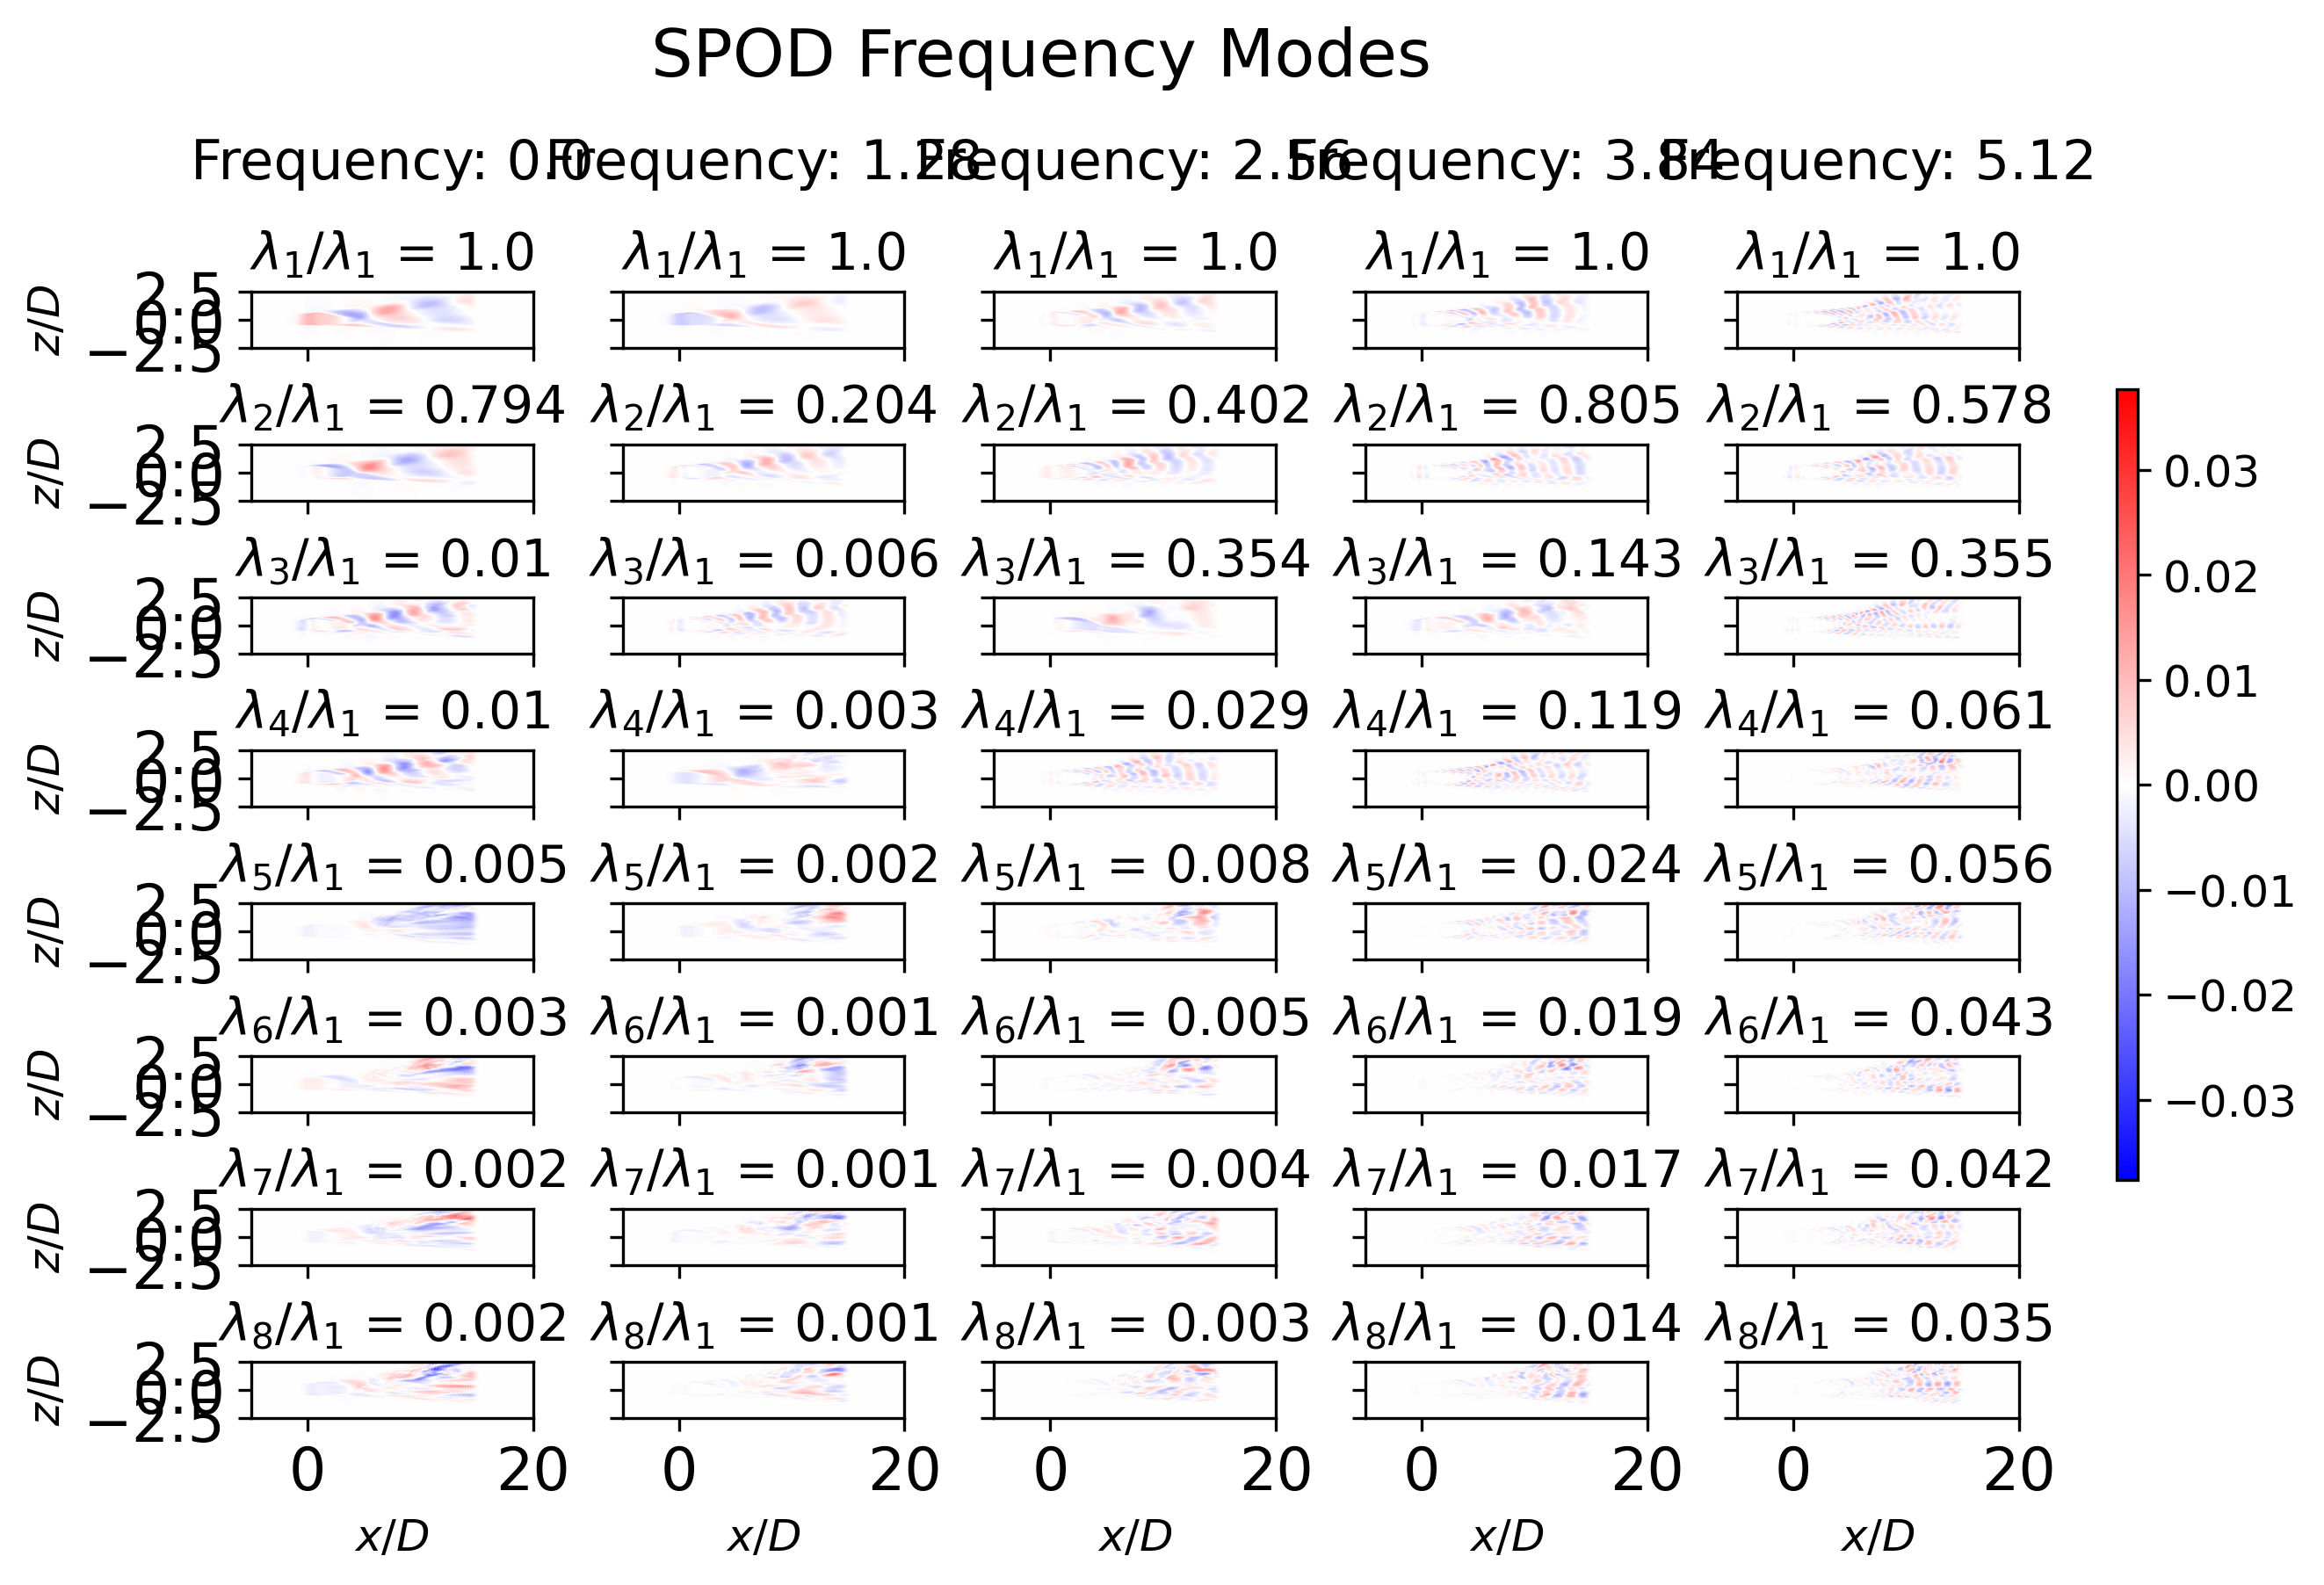

In [30]:
Ms = np.array([0, 1, 2, 3, 4, 5, 6, 7])
fs = np.array([0, 1, 2, 3, 4])
plot_spod_modes(P, L, f, Ms, fs, mode_path = os.path.join(data_folder, "spod_modes.png"))

In [31]:
data_rec = spod.reconstruct_time_method(vecs,dt,f,P,Ms,fs, method = "fast", save_path=save_path)

--------------------------------------
Time-method reconstruction ...
--------------------------------------
Using user specified method...
Using default weight...
Using default nDFT...
Using default Hamming window...
Using default nOvlp...
--------------------------------------
SPOD parameters summary:
--------------------------------------
number of DFT points : 32
number of blocks is  : 33
number of overlap is : 16
Window function      : Hamming
Weight function      : unity
Running method       : fast
Calculate phi_tilda finished ...
Memory usage: 2.46 GB
(40, 40)
Calculate phi_inv finished ...
(40, 556)
Calculate A_tilda finished ...
--------------------------------------
Time-method reconstruction finished
Memory usage: 3.28 GB
Run time    : 2.44 s
--------------------------------------


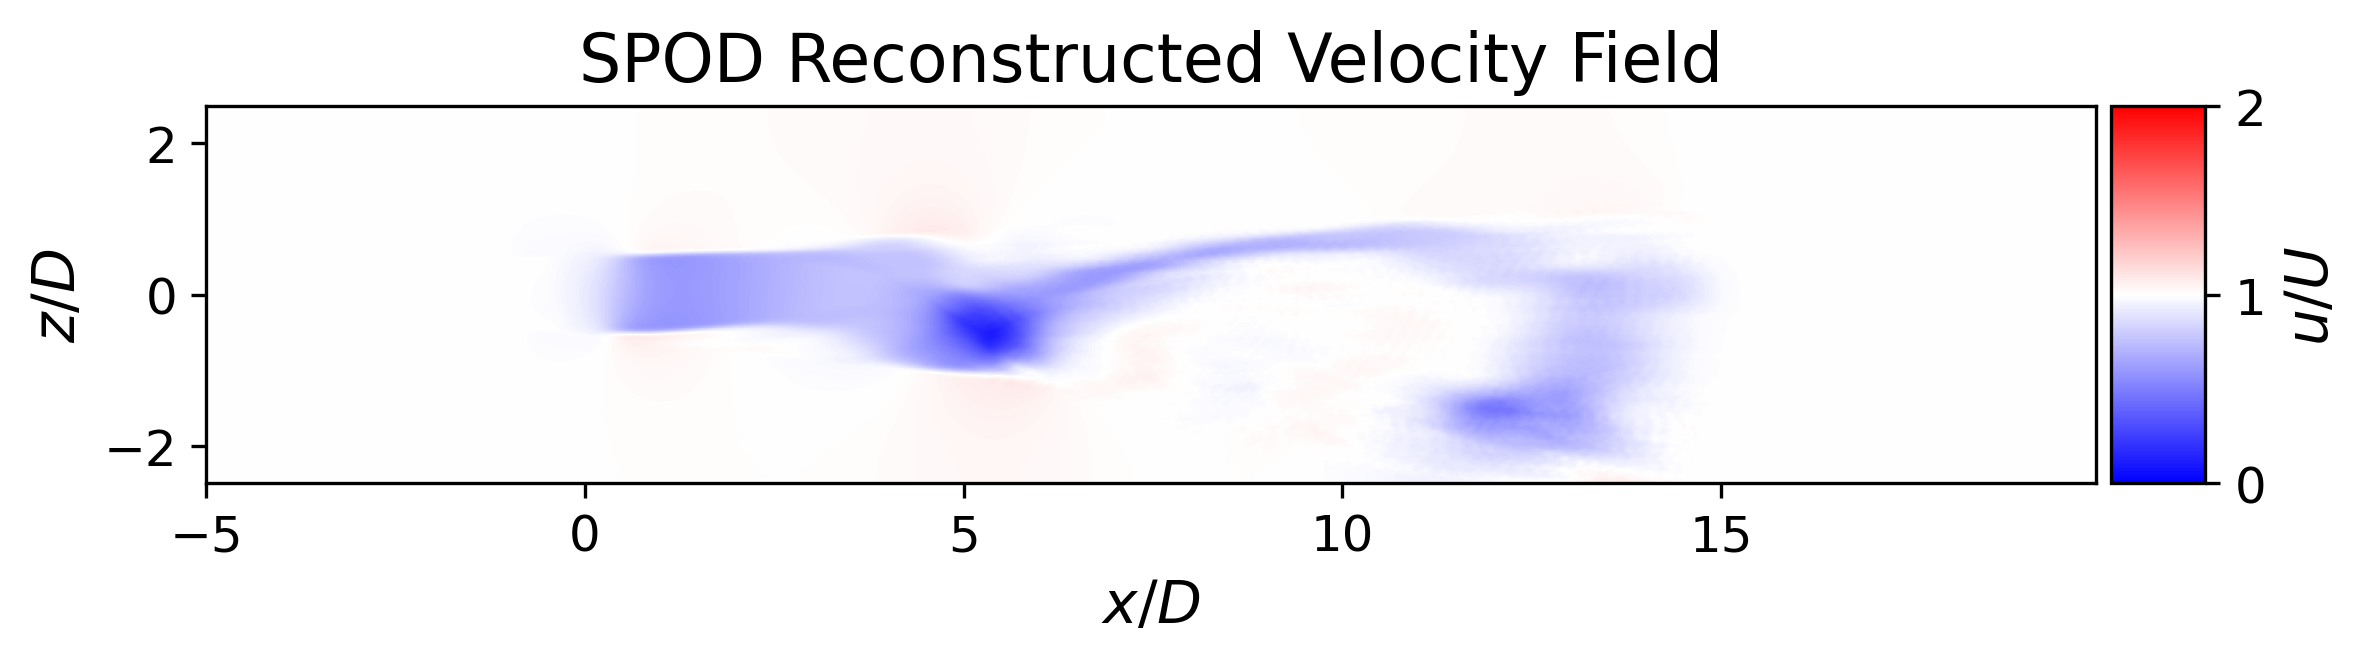

In [32]:
tidx = 250
data_rec_tidx = da_mean + data_rec.reshape(nt, nx, nz)[tidx, :, :]
plot_field(data_rec_tidx, 0, 2, "SPOD Reconstructed Velocity Field", keylab['u']);

In [33]:
rmse(ds5.u, data_rec_tidx, tidx)

0.024523528913835396

In [34]:
ds5["time"].values.shape

(556,)

In [35]:
da_mean = ds5.u.mean(dim = "time")
(nt, nx, nz) = ds5.u.shape
rmse_vals = []
for t in ds5["time"].values:
    data_rec_t = da_mean + data_rec.reshape(nt, nx, nz)[t, :, :]
    rmse_vals = np.append(rmse_vals, rmse(ds5.u, data_rec_t, t))
rmse_vals

array([0.0283568 , 0.02859848, 0.0290067 , 0.02968713, 0.03035192,
       0.03024899, 0.02980589, 0.02910839, 0.02822496, 0.02738088,
       0.02658033, 0.02600186, 0.02572067, 0.02529129, 0.02444648,
       0.02347045, 0.02307118, 0.02277821, 0.02254332, 0.02246419,
       0.02263068, 0.02286432, 0.02309111, 0.02360279, 0.02390874,
       0.02395107, 0.02423006, 0.02474879, 0.02552041, 0.02607804,
       0.02582051, 0.02563853, 0.02583546, 0.02623993, 0.02687021,
       0.02754056, 0.02824108, 0.0286419 , 0.02847036, 0.02811804,
       0.02832594, 0.02846051, 0.02768732, 0.02683308, 0.02630509,
       0.02643577, 0.02676333, 0.02709441, 0.02718788, 0.02735693,
       0.02718468, 0.02662607, 0.02620197, 0.02619099, 0.02594834,
       0.0252965 , 0.024634  , 0.02436627, 0.02428242, 0.02415017,
       0.02406099, 0.0239467 , 0.02379042, 0.02366875, 0.02357339,
       0.02349597, 0.02346941, 0.02361334, 0.0239326 , 0.02436681,
       0.02513152, 0.02592426, 0.02588627, 0.02562494, 0.02572

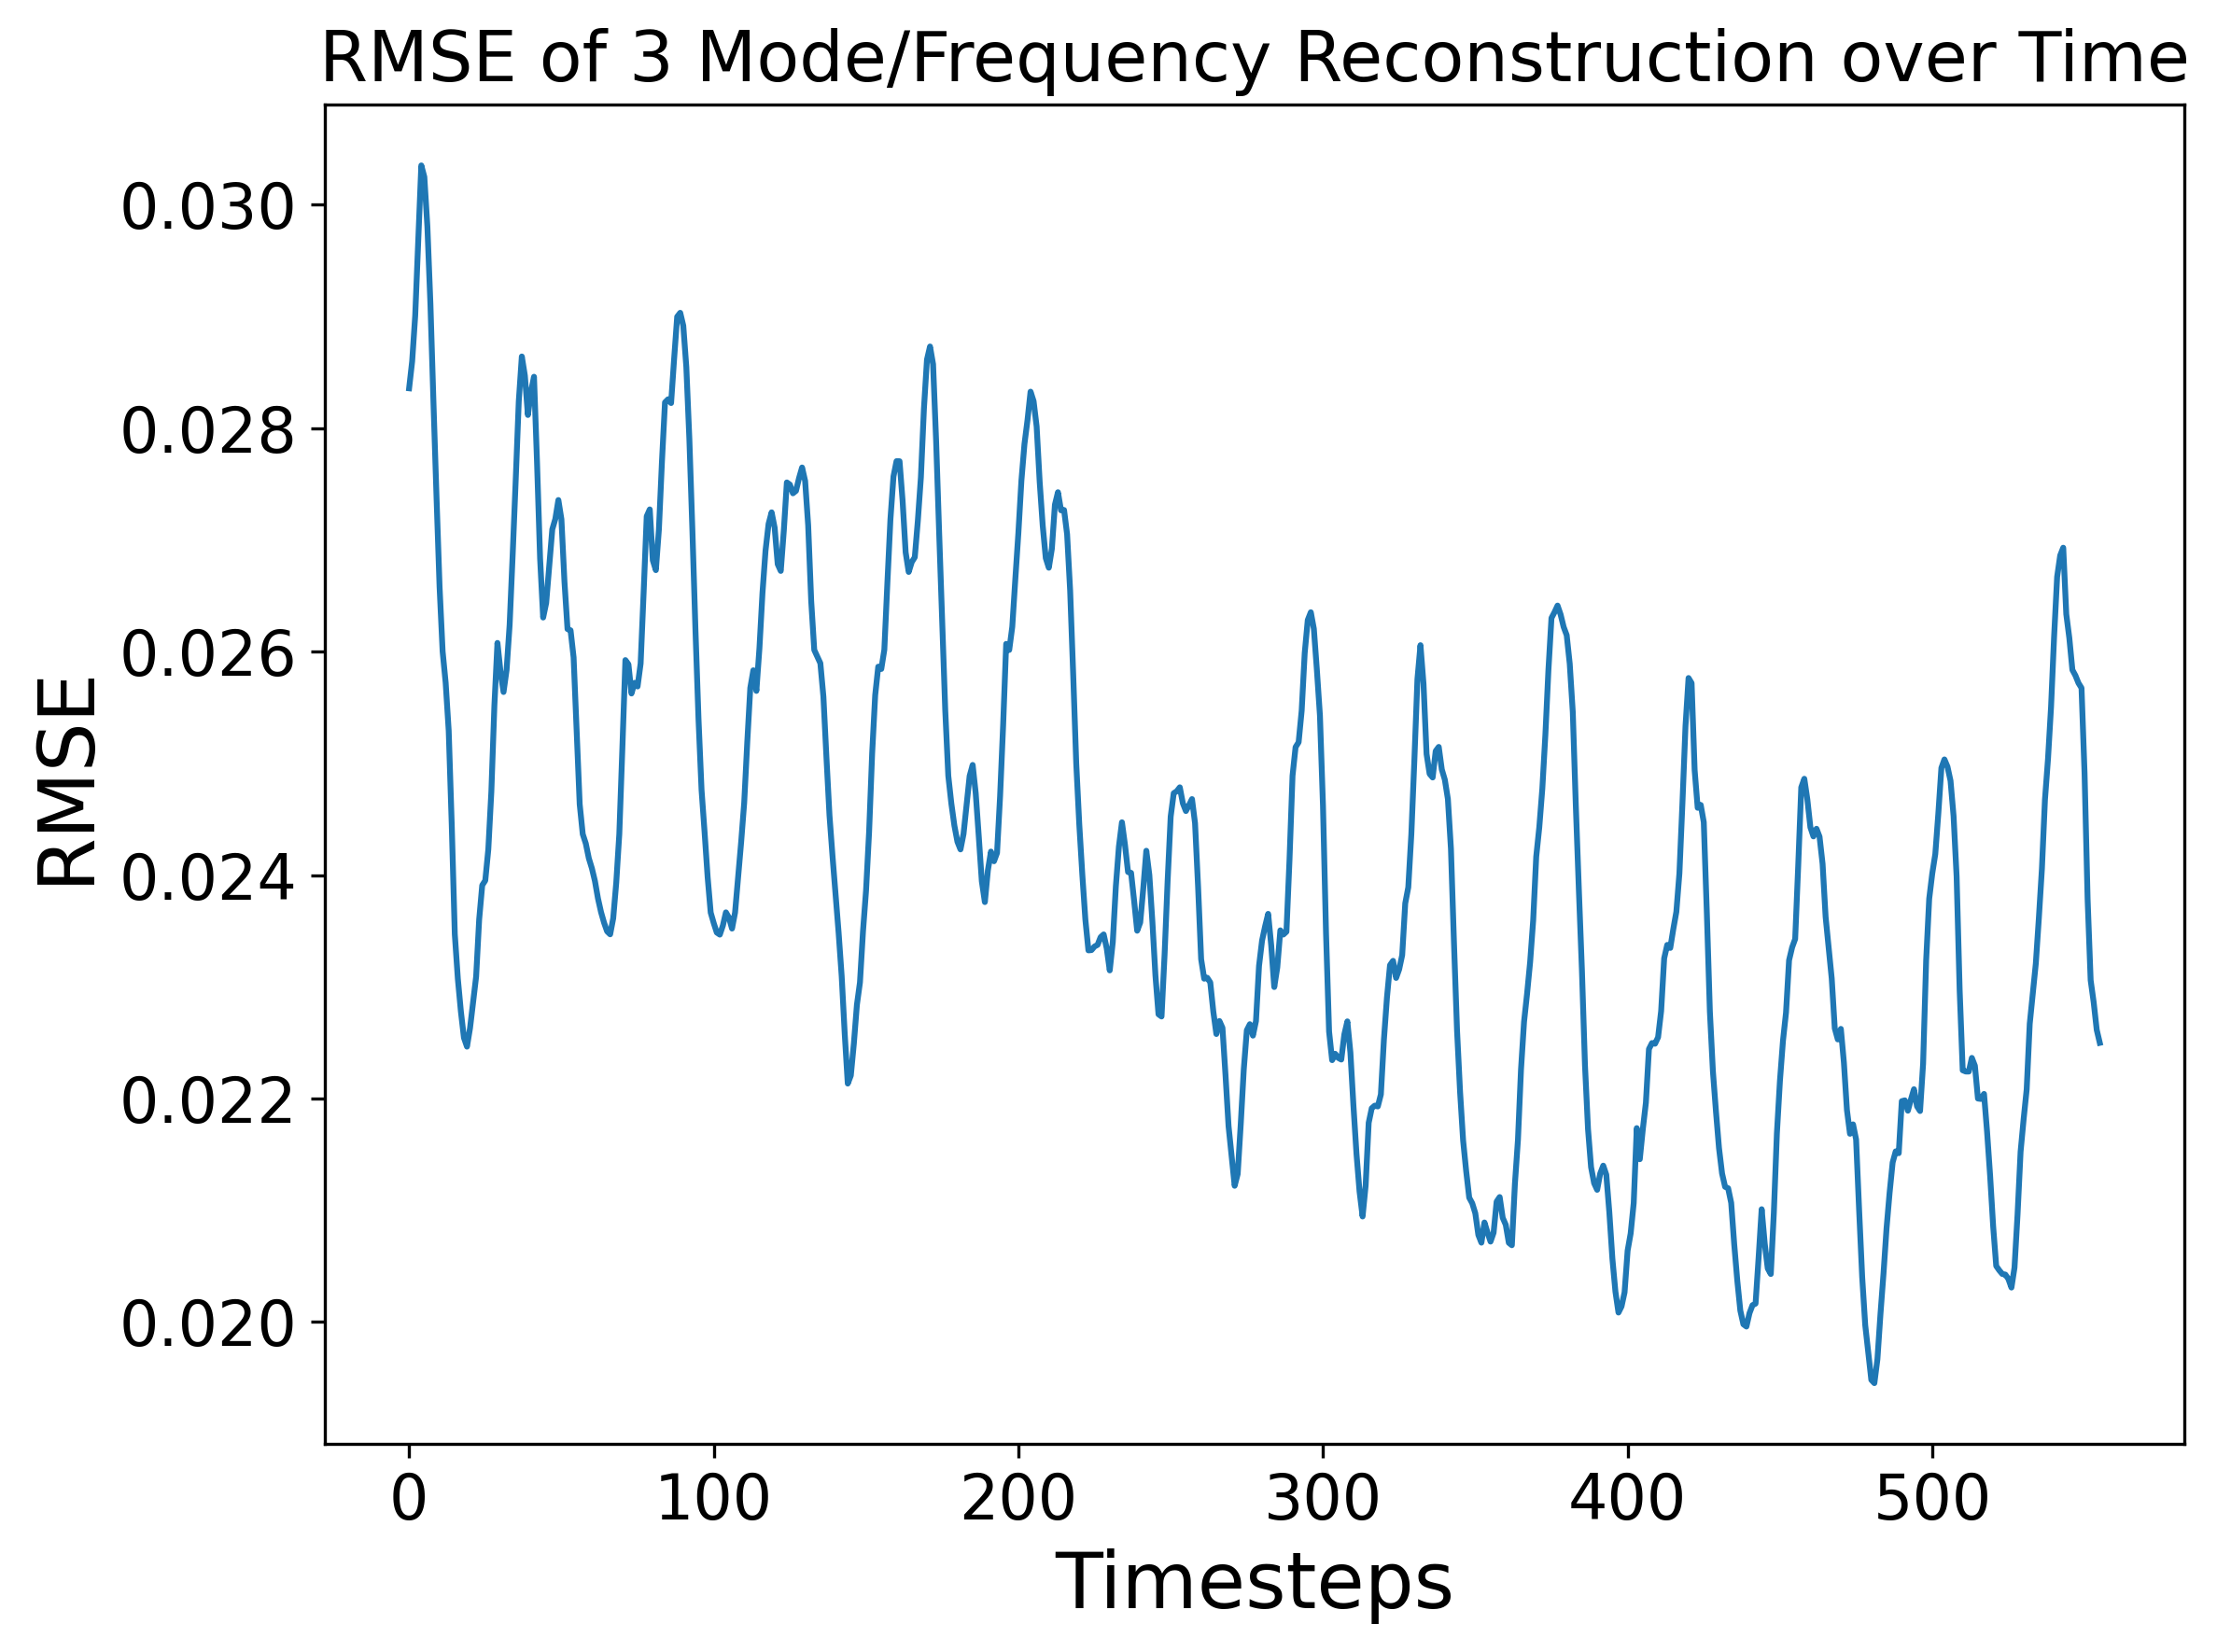

In [36]:
fig, ax = plt.subplots(1, 1, dpi = 300)
ax.plot(ds5["time"].values, rmse_vals)
ax.set_title("RMSE of 3 Mode/Frequency Reconstruction over Time", size = 18)
ax.set_ylabel("RMSE")
ax.set_xlabel("Timesteps")
fig.tight_layout()
fig.savefig(os.path.join(data_folder, "spod_rmse.png"), dpi = 300)

# Laminar Flow

I began by exploration with laminar flows at a medium resolution of (nx, ny, nz) = (256, 128, 128). I also started with a high amplitude and frequency of movemement with frequency $f = 1$ for all moving turbines and amplitude of $A = 0.5$ for surging turbines and $A = 5^\circ$ for pitching turbines.

## Stationary Turbine

In [37]:
# stationary_ds  = get_clean_data("stationary_data_r_256_t_0.nc")

In [38]:
# plot_u(stationary_ds, 1)

In [39]:
# plot_p(stationary_ds, 1800)

## Surging Turbine

In [40]:
# surging_ds  = get_clean_data("surging_data_r_256_t_0.nc")

In [41]:
# plot_u(surging_ds, 1800)

In [42]:
# plot_p(surging_ds, 1800)

In [43]:
# modes, eigenvals = get_u_pod_modes(surging_ds, 6)

In [44]:
# modes, eigs = get_p_pod_modes(surging_ds, 4)

In [45]:
# params = {"time_step":0.062, "n_space_dims":2, "n_variables":1, "n_dft":50, "overlap":50, "mean_type":"longtime", "n_modes_saved":6}

In [46]:
# standard  = spod_standard(params=params, comm=None)
# spod = standard.fit(data_list=surging_ds.u)

In [47]:
# spod.plot_eigs()

In [48]:
# spod.plot_eigs_vs_frequency()

In [49]:
# f1, f1_idx = spod.find_nearest_freq(freq_req=2 * math.pi, freq=spod.freq)
# spod.plot_2d_modes_at_frequency(freq_req=f1, freq=spod.freq, modes_idx=[0,1,2], x1=surging_ds.x, x2=surging_ds.z, equal_axes=True)

## Pitching Turbine

In [50]:
# pitching_ds = get_clean_data("pitching_data_r_256_t_0.nc")

In [51]:
# plot_u(pitching_ds, 1800)

In [52]:
# plot_p(pitching_ds, 1800)

In [53]:
# modes, eigenvals = get_u_pod_modes(pitching_ds, 6)

In [54]:
# modes, eigenvals = get_p_pod_modes(pitching_ds, 6)

In [55]:
# spod = standard.fit(data_list=pitching_ds.u)

In [56]:
# spod.plot_eigs_vs_frequency()

## Surging and Pitching Turbine

In [57]:
# surging_pitching_ds = get_clean_data("surging_pitching_data_r_256_t_0.nc")

In [58]:
# plot_u(surging_pitching_ds, 1800)

In [59]:
# plot_p(surging_pitching_ds, 1800)

In [60]:
# modes, eigenvals = get_u_pod_modes(surging_pitching_ds, 6)

In [61]:
# modes, eigenvals = get_p_pod_modes(surging_pitching_ds, 6)